# Computational Statistics 
# TP 2 : Expectation-Maximisation algorithm – Importance sampling

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import sklearn.cluster as skl 
import pandas as pd
import copy
np.random.seed(7)

## Exercice 1 : Discrete distributions

### Question 1

Réponse sur feuille.

### Question 2

In [3]:
def sampleX(x,p,n):
  #x : valeurs prises par X
  #p : probabilites de realisations de chaque xi
  #n : nombre de fois qu'on veut generer X 
  U = np.random.uniform(0,1,n)
  X = np.zeros(n)
  for i in range(n):
    if(U[i] <= p[0]):
      X[i] = x[0]
    else:
      for j in range(1, len(x)):
        if(np.sum(p[:j]) < U[i] and U[i] <= np.sum(p[:j+1])):
          X[i] = x[j]
  return X


### Question 3

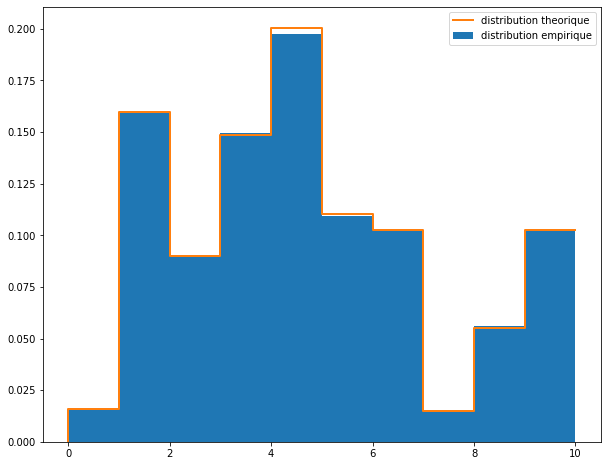

In [ ]:
N = 100000
p = np.random.random(10) #On genere des probas de facon aleatoire
p = p / np.sum(p) #On normalise les probas
x = np.arange(0, len(p)) #On prend par defaut x1=0, x2=1, ... suite d'entiers

X = sampleX(x,p,N)

plt.figure(figsize=(10,8))
plt.hist(X,range(0,len(p)+1), density = True, label = 'distribution empirique')
p_courbe = np.concatenate((np.array([0]),p)) #on ajoute le point d'origine pour bien tracer la densite theorique
plt.step(np.arange(0,len(p)+1), p_courbe, linewidth = 2, label='distribution theorique')
plt.legend()



On remarque que la courbe de la densité théorique est cohérente avec nos réalisations de cette loi car on voit qu'elle est très proche de l'histogramme. Ainsi, on a plutôt bien simuler nos réalisations X grâce à la fonction *sampleX*.

On remarque que nos réalisations aléatoires de X sont cohérentes avec la courbe de la densité théorique de cette même loi car on voit que cette courbe est très proche de notre histogramme. Plus on augmente le nombre de réalisations aléatoires de X, plus l'écart entre la courbe de la densité et notre histogramme sera faible et inversement si on diminue N, cette écart va se creuser.

## Exercice 2 : Gaussian mixture model and the EM algorithm

### Question 1

Réponse sur feuille.

### Question 2

Text(0.5, 1.0, 'Sample Gaussian mixture law')

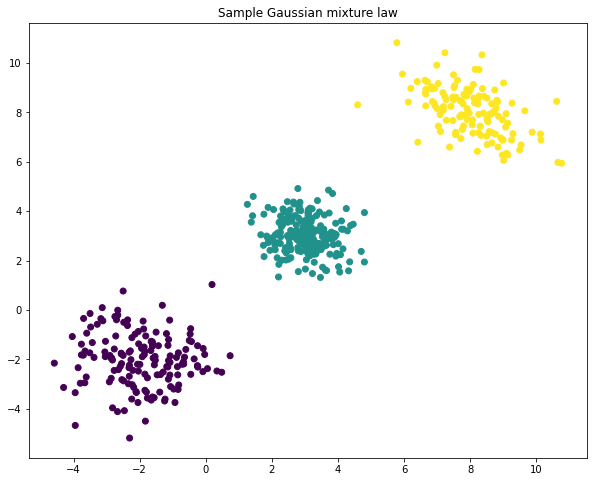

In [ ]:
n=500

#Parametres du modele de melange gaussien

mus=[[-2,-2], [3,3], [8,8]]

sigmas=[[[1,0],[0,1]], [[0.5,0],[0,0.5]], [[1,-0.5],[-0.5,1]]]
alpha=[0.3,0.4,0.3]

#Permet de generer n echantillons issus d'un modele de melange gaussien
def sampleG(alpha,mus,sigmas,n):
  z = np.arange(1, len(alpha)+1) #valeurs prises par Z
  Z = sampleX(z, alpha, n)
  sample = np.zeros(shape=(n,2))
  label = np.zeros(n)
  indice = 0 #Permet de savoir ou on doit remplir sample et label
  for j in Z:
    sample[indice, :] = np.random.multivariate_normal(mus[int(j)-1],sigmas[int(j)-1], 1)
    label[indice] = j
    indice += 1
  return sample, label

G = sampleG(alpha,mus,sigmas,n)
plt.figure(figsize=(10,8))
plt.scatter(G[0][:,0], G[0][:,1], c=G[1])
plt.title('Sample Gaussian mixture law')


### Question 3

Je me suis inspiré de l'algorithme EM en pseudo-code de ce document : https://perso.telecom-paristech.fr/bonald/documents/gmm.pdf (page 4)
Pour les calculs théoriques, voir réponse sur feuille.

In [8]:
def logLikelihood(X, alpha, mu, sigma): 
    L = np.zeros((X.shape[0], alpha.shape[0]))
    for j in range(alpha.shape[0]):
        phi = multivariate_normal.pdf(X, mu[j], sigma[j] , allow_singular =True)
        L[:,j] = alpha[j] * phi    
    logL = np.log(np.sum(L, axis = 1))
  
    return np.sum(logL)

def EM(X, iterations, K):
  #X : jeu de donnees
  #iteration : nombre d'iterations que l'on souhaite
  #K : nombre de clusters 

  n = X.shape[0]

  #Choix des parametres d'initialisation alpha, mu et sigma
  mu = []
  kmeans = skl.KMeans(n_clusters=K).fit(X)
  labels = kmeans.labels_
  sigma = []
  alpha = np.zeros(K)
  for i in range(K):
    index = np.where(labels==i)[0]
    mu.append(np.apply_along_axis(np.mean,0,X[index,:])) 
    sigma.append(np.cov(X[index,0],X[index,1])) 
    alpha[i] = len(index)/X.shape[0]

  mu = np.array(mu)

  logL = np.zeros(iterations+1)
  logL[0] = logLikelihood(X, alpha, mu, sigma)

  for l in range(iterations):
    #Expectation
    P = np.zeros((n, K))
    for i in range(n):
      s = 0
      for j in range(K):
        P[i,j] = alpha[j] * multivariate_normal.pdf(X[i], mean=mu[j], cov=sigma[j])
        s = s + P[i,j]
      for j in range(K):
        if(s!=0):
          P[i,j] = P[i,j] / s

    #Maximisation
    for j in range(K):
      alpha[j] = 0
      mu[j] = np.zeros(X.shape[1])
      for i in range(n):
        alpha[j] = alpha[j] + P[i,j]
        mu[j] = mu[j] + P[i,j] * X[i]
      if(alpha[j]!=0):
        mu[j] = mu[j] / alpha[j]
      sigma[j] = np.zeros((X.shape[1], X.shape[1]))

      for i in range(n):
        terme = X[i] - mu[j]
        terme = np.reshape(terme, (-1,1))
        sigma[j] = sigma[j] + P[i,j] * terme * np.transpose(terme)
      if(alpha[j]!=0):
        sigma[j] = sigma[j] / alpha[j]
    alpha /= np.sum(alpha)
    logL[l+1] = logLikelihood(X, alpha, mu, sigma)

  return alpha, mu, sigma, logL

In [ ]:
alpha_em, mu_em, sigma_em, logL  = EM(G[0], 100, len(alpha))

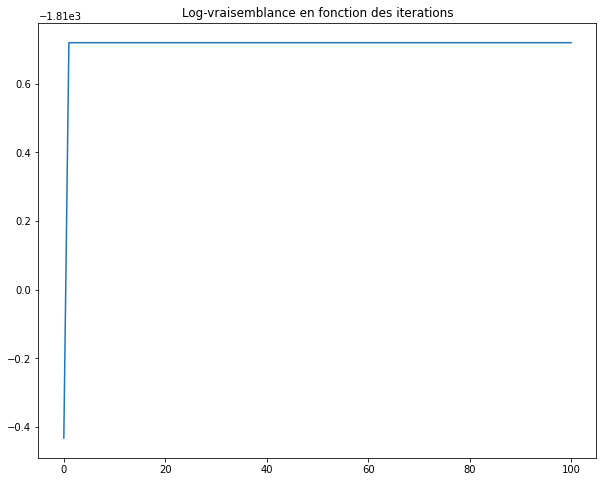

In [ ]:
# Plot the results 

plt.figure(figsize=(10,8))
plt.plot(range(101),logL)
plt.title('Log-vraisemblance en fonction des iterations')
plt.show()

### Question 4

In [ ]:
for i in range(len(alpha)):
    print('\n----Cluster ',i+1,'----')
    print('Mu original : ', mus[i])
    print('Mu estime : ', mu_em[i])
    print('Alpha original : ', alpha[i])
    print('Alpha estime : ', alpha_em[i])
    print('Sigma original : ', sigmas[i])
    print('Sigma estime : ', sigma_em[i])


----Cluster  1 ----
Mu original :  [-2, -2]
Mu estime :  [-1.95030169 -2.01806015]
Alpha original :  0.3
Alpha estime :  0.3139985984535027
Sigma original :  [[1, 0], [0, 1]]
Sigma estime :  [[ 1.19199003 -0.05446378]
 [-0.05446378  1.14642581]]

----Cluster  2 ----
Mu original :  [3, 3]
Mu estime :  [3.00861573 3.04163268]
Alpha original :  0.4
Alpha estime :  0.4220014015465204
Sigma original :  [[0.5, 0], [0, 0.5]]
Sigma estime :  [[ 0.48205836 -0.08784578]
 [-0.08784578  0.52122035]]

----Cluster  3 ----
Mu original :  [8, 8]
Mu estime :  [8.03008494 8.05684854]
Alpha original :  0.3
Alpha estime :  0.2639999999999769
Sigma original :  [[1, -0.5], [-0.5, 1]]
Sigma estime :  [[ 1.02805341 -0.50163494]
 [-0.50163494  0.91402549]]


Notre algorithme EM converge vers la solution optimale. En effet, on remarque que les paramètres alpha, mu et sigma estimés pour chaque cluster (ou label) sont très proche de ceux d'origine issus de notre échantillon X d'après les résultats ci-dessus.
Donc l'algorithme EM est efficace pour estimer les paramètres issus d'un modèle de mélange Gaussien.

### Question 5

Text(0, 0.5, 'death')

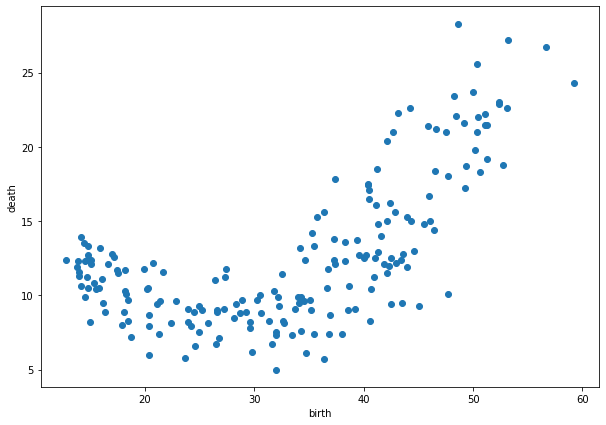

In [4]:
data = pd.read_csv('/content/Crude-BirthDeath-Rate.csv')
X = np.array(data)
#Colonne 1 : birth
#Colonne 2 : death
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1])
plt.xlabel("birth")
plt.ylabel("death")

On ne reconnaît pas de modèle particulier quand on représente sur un graphe les données donc on peut utilisé un modèle de mélange gaussien pour déterminer les différents clusters de ce jeu de données.

### Question 6


In [6]:
#Degres de libertes d'un GMM
def df(m):
  #chaque alpha contient une valeur
  #chaque mu contient deux valeurs (vecteurs de R^2)
  #chaque sigma est une matrice 2x2 donc contient 4 valeurs
  return m + 2*m + 4*m

#Calcul le BIC
def BIC(X, alpha, mu, sigma, m):
  n = X.shape[0]
  logL = logLikelihood(X, alpha, mu, sigma)
  return -logL + 0.5 * df(m) * np.log(n)

#Permet de representer nos resultats sur un graphique
def graph(X, mu, sigma, m):
    plt.figure(figsize=(10,8))
    plt.scatter(X[:,0], X[:,1]) 
    x = np.linspace(0, 65)
    y = np.linspace(0, 40)
    plt.ylabel('Death')
    plt.xlabel('Birth')
    U, V = np.meshgrid(x, y)

    #Trace de la densite associe
    for i in range(m): 
        Z = multivariate_normal.pdf(np.array([U.ravel(), V.ravel()]).T, mu[i], sigma[i])
        Z = Z.reshape(V.shape)
        plt.contour(U, V, -Z) #On trace avec -Z pour enlever des "lignes parasites" sur nos graphs

    plt.show()
    print('\n')

----Pour m =  1 cluster(s)----
Alpha estime :
  [1.]
Mu estime :
  [[33.03608247 12.6443299 ]]
Sigma estime :
  [array([[142.33003826,  37.51541078],
       [ 37.51541078,  24.16102455]])]
BIC :  1307.7858616883384


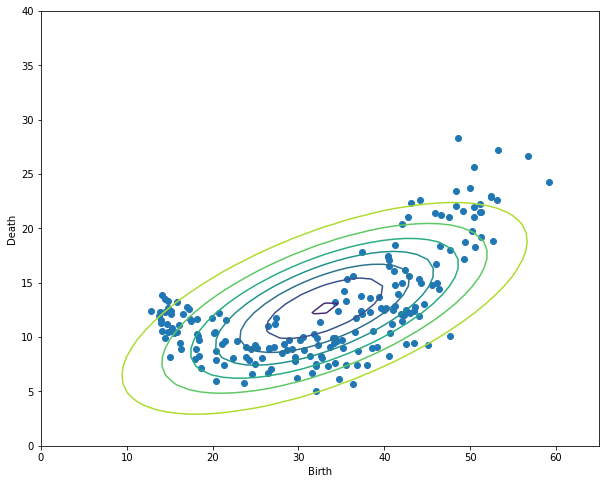



----Pour m =  2 cluster(s)----
Alpha estime :
  [0.44838816 0.55161184]
Mu estime :
  [[21.85807946  9.78547608]
 [42.12233458 14.96820353]]
Sigma estime :
  [array([[40.50705018, -7.70154865],
       [-7.70154865,  3.90144636]]), array([[40.97265763, 27.17930702],
       [27.17930702, 28.58540388]])]
BIC :  1223.3524453056884


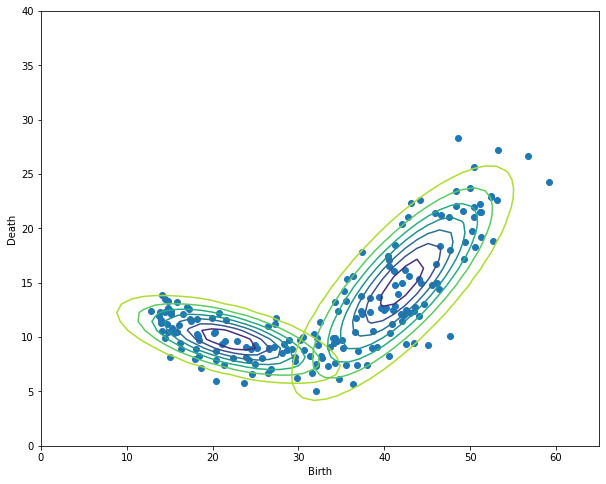



----Pour m =  3 cluster(s)----
Alpha estime :
  [0.46824938 0.18810738 0.34364324]
Mu estime :
  [[43.14125213 15.96190241]
 [16.1457953  11.50504388]
 [28.51234506  8.74743036]]
Sigma estime :
  [array([[37.3834825 , 25.11463193],
       [25.11463193, 26.90137941]]), array([[ 4.56185948, -0.86227466],
       [-0.86227466,  1.56223364]]), array([[44.9771695 ,  1.57766464],
       [ 1.57766464,  1.90386595]])]
BIC :  1218.6197239975913


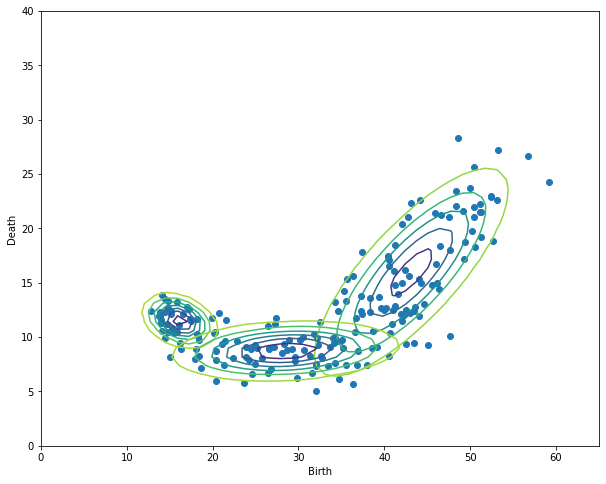



----Pour m =  4 cluster(s)----
Alpha estime :
  [0.26848438 0.15323203 0.40048916 0.17779444]
Mu estime :
  [[40.5644081  13.21184828]
 [15.44545879 11.69169383]
 [27.612691    8.74741967]
 [49.04456167 21.38630663]]
Sigma estime :
  [array([[11.338193  ,  0.62735151],
       [ 0.62735151,  5.76158216]]), array([[ 2.13751922, -0.46875853],
       [-0.46875853,  1.41564139]]), array([[40.21214713, -1.51257913],
       [-1.51257913,  2.36493969]]), array([[16.19526847,  5.42202229],
       [ 5.42202229,  8.7478327 ]])]
BIC :  1229.0285599253978


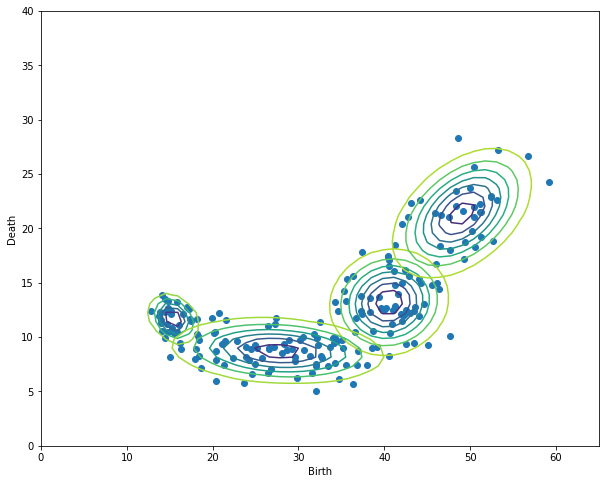



----Pour m =  5 cluster(s)----
Alpha estime :
  [0.27663114 0.21689722 0.19615812 0.17826019 0.13205333]
Mu estime :
  [[40.59541549 13.09046904]
 [21.89343045  9.00226839]
 [32.18113151  8.63683138]
 [49.04066478 21.37003228]
 [15.16746082 11.8658192 ]]
Sigma estime :
  [array([[10.9823282 ,  0.4151097 ],
       [ 0.4151097 ,  6.06187983]]), array([[15.99889919, -2.16482412],
       [-2.16482412,  2.70103378]]), array([[10.37116232, -1.10839252],
       [-1.10839252,  2.21476772]]), array([[16.14961069,  5.45523266],
       [ 5.45523266,  8.82115993]]), array([[ 1.54611261, -0.1767248 ],
       [-0.1767248 ,  1.18552562]])]
BIC :  1243.1673992136734


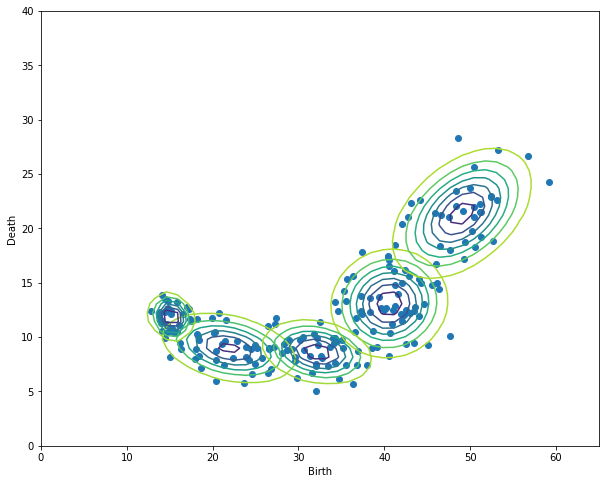



----Pour m =  6 cluster(s)----
Alpha estime :
  [0.13974276 0.14973315 0.17767316 0.09360031 0.34758068 0.09166993]
Mu estime :
  [[18.24150503 10.40974512]
 [39.78653842 12.4542329 ]
 [49.15511299 21.40092852]
 [14.59677824 11.76656765]
 [30.3266218   8.63313413]
 [42.42225444 15.49467883]]
Sigma estime :
  [array([[ 5.11229045, -1.43250285],
       [-1.43250285,  3.02520016]]), array([[10.33592118, -2.75366555],
       [-2.75366555,  2.01951082]]), array([[15.07946991,  4.89140272],
       [ 4.89140272,  8.67901622]]), array([[ 0.47993826, -0.23276111],
       [-0.23276111,  1.45968067]]), array([[31.15507623,  0.71779461],
       [ 0.71779461,  2.16889015]]), array([[ 5.33164873, -2.39793872],
       [-2.39793872,  2.91469918]])]
BIC :  1254.2127308351025


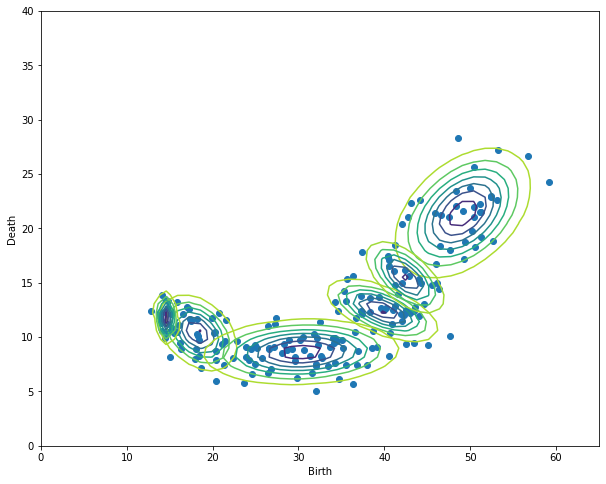



----Pour m =  7 cluster(s)----
Alpha estime :
  [0.25848789 0.06223075 0.16678016 0.18230904 0.09670368 0.18430257
 0.0491859 ]
Mu estime :
  [[31.99633747  8.53439647]
 [42.45795189 16.0402787 ]
 [18.73140608 10.06523238]
 [48.93245101 21.32655424]
 [14.62364167 11.71471197]
 [40.22339726 12.48963389]
 [25.43280802  8.91842924]]
Sigma estime :
  [array([[18.23669803,  0.32105967],
       [ 0.32105967,  1.92851155]]), array([[ 6.73273657, -2.68592933],
       [-2.68592933,  1.19048377]]), array([[ 5.9141328 , -1.88898812],
       [-1.88898812,  3.38764769]]), array([[16.48948868,  5.53635595],
       [ 5.53635595,  8.67113039]]), array([[ 0.50128033, -0.26512219],
       [-0.26512219,  1.57819657]]), array([[10.47953262, -2.23043924],
       [-2.23043924,  2.3521632 ]]), array([[1.56334896, 1.78861838],
       [1.78861838, 3.04447659]])]
BIC :  1263.9611692626847


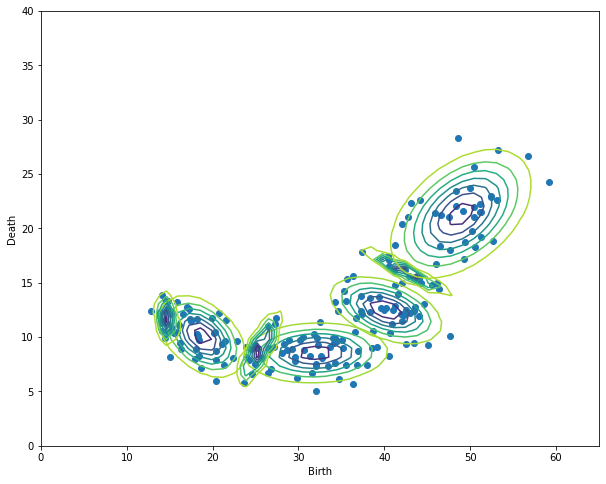



Le meilleur choix pour le nombre de cluster selon le BIC est :  3 clusters.


In [9]:
iterations = 100
#On applique l'algorithme EM sur ce jeu de donnees en faisant varier le nombre de clusters de 1 a 4
BIC_values = np.zeros(7)
for m in range(1,8):
  print('----Pour m = ', m,'cluster(s)----')
  alpha, mu, sigma, logL = EM(X, iterations, m)
  BIC_values[m-1] = BIC(X, alpha, mu, sigma, m)
  print('Alpha estime :\n ', alpha)
  print('Mu estime :\n ', mu)
  print('Sigma estime :\n ', sigma)
  print('BIC : ', BIC_values[m-1])
  graph(X, mu, sigma, m)
print('Le meilleur choix pour le nombre de cluster selon le BIC est : ', np.argmin(BIC_values)+1, 'clusters.')

## Exercice 3 : Importance sampling

### Question 1

In [10]:
def f(x):
  if x >0:
    return 2 * np.sin(np.pi * x / 1.5)
  return 0

def p(x):
  if x>0: 
    return x**(1.65 - 1)*np.exp(-x**2 / 2)
  return 0

def q(x, mu=0.8, sigma=np.sqrt(1.5)):
    return 2 / np.sqrt(2*np.pi*(sigma)**2) * np.exp(-(mu-x)**2/(2*(sigma)**2))

def simple_importance_sampling(n, mu=0.8, sigma=np.sqrt(1.5)):
  x = np.zeros(n)
  i = 0
  while i<n:
    sample = np.random.normal(mu, sigma**2, 1)
    if sample > 0:
      x[i] = sample
      i += 1
  
  #Importance weights
  W = np.zeros(n)
  for k in range(n):
    W[k] = p(x[k]) / q(x[k], mu, sigma)
  
  W_normalized = W / np.mean(W) #Normalized importance weights

  #Esperance de f(X)
  X = np.zeros(n)
  for k in range(n):
    X[k] = W_normalized[k] * f(x[k])
  E = np.mean(X)

  #Approximation de mu
  E_2 = np.zeros(n)
  for k in range(n):
    E_2[k] = W_normalized[k] * (f(x[k])**2)
  
  #Approximation de sigma^2
  V = np.mean(E_2) - E**2

  return E, V, W



In [ ]:
print(simple_importance_sampling(10*6))

(0.5027194902875526, 1.614227606817855, array([0.71796578, 0.42394994, 0.93661082, 0.84124529, 0.07394084,
       0.01332263, 0.82509632, 0.42377585, 0.75671805, 0.9625188 ,
       0.24152614, 0.96095694, 0.96297288, 0.65817247, 0.68754254,
       0.62893866, 0.53191453, 0.15634706, 0.41646735, 0.89430738,
       0.17582239, 0.70551946, 0.94968567, 0.84313799, 0.50150324,
       0.93314133, 0.36576842, 0.09993305, 0.65759312, 0.95281698,
       0.95448754, 0.20593687, 0.82476259, 0.60947875, 0.7121598 ,
       0.06219617, 0.64667234, 0.90670381, 0.6798173 , 0.76417585,
       0.52750789, 0.5046022 , 0.65070466, 0.16119563, 0.10428673,
       0.29040415, 0.32333123, 0.92890541, 0.86666635, 0.80343533,
       0.62091353, 0.12538098, 0.16555889, 0.44985711, 0.65710246,
       0.96240254, 0.77250519, 0.08583772, 0.79023368, 0.51593667]))


### Question 2

In [ ]:
N = [10, 100, 10**3, 10**4]

for n in N:
  E, V, W = simple_importance_sampling(n)
  print("N = ", n)
  print("Mu estime = ", E)
  print("Sigma^2 estime = ", V)
  print("\n")


N =  10
Mu estime =  0.8095210874297093
Sigma^2 estime =  1.2904121814172471


N =  100
Mu estime =  0.5592358202094367
Sigma^2 estime =  1.8505877433667046


N =  1000
Mu estime =  0.6188218848851794
Sigma^2 estime =  1.7106805580017714


N =  10000
Mu estime =  0.6994338886531064
Sigma^2 estime =  1.690028410267939




### Question 3

N =  10


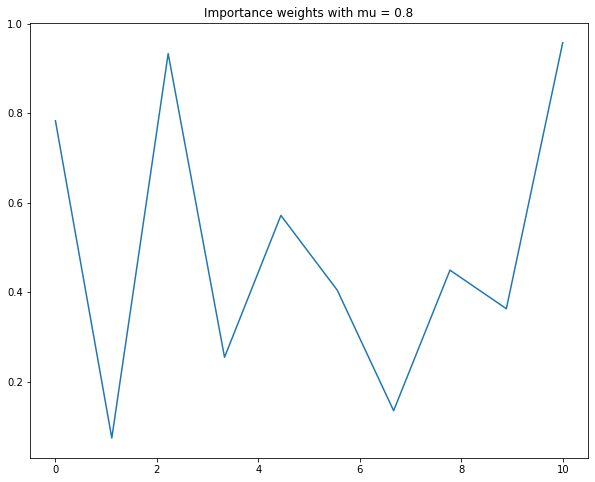

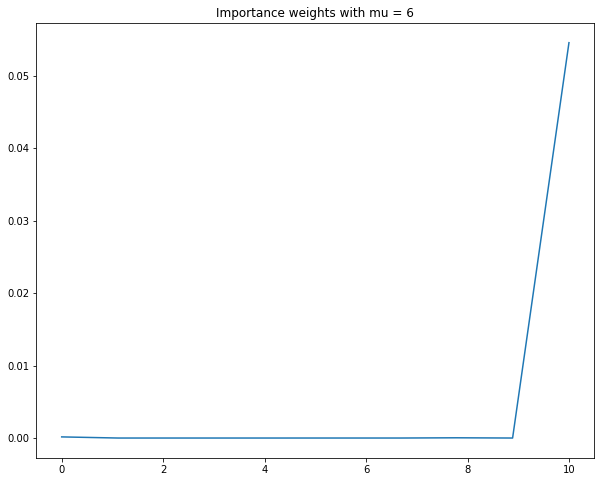

Mu estime =  0.2526720375775763
Sigma^2 estime =  2.4127656621328706


N =  100


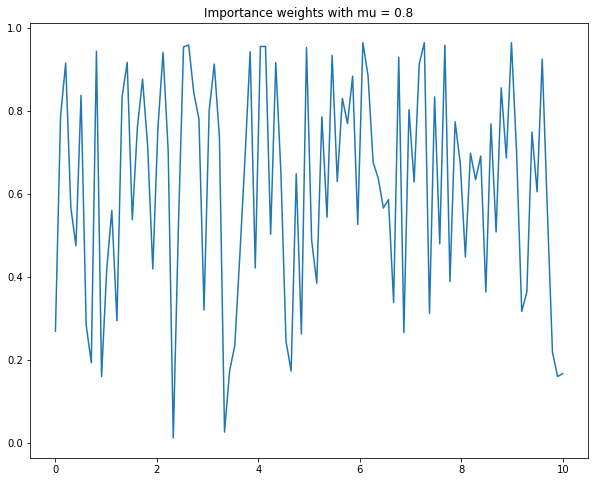

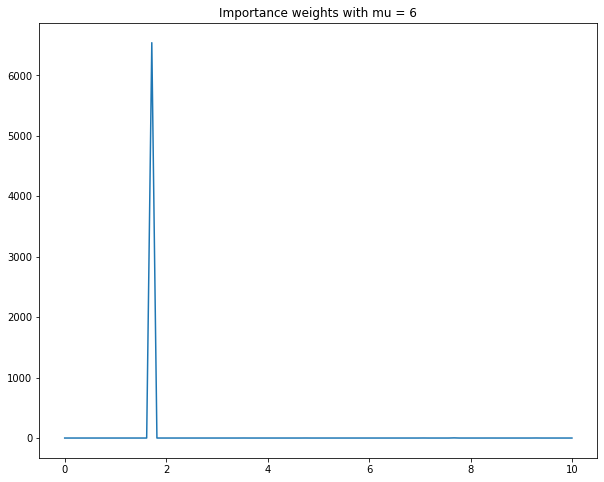

Mu estime =  0.542690218534735
Sigma^2 estime =  1.780301165474688


N =  1000


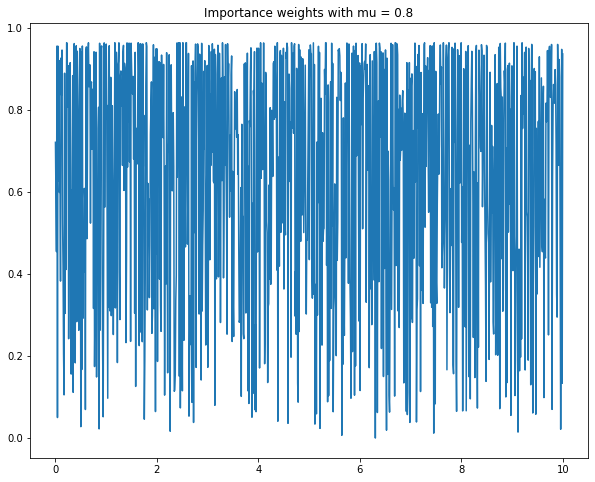

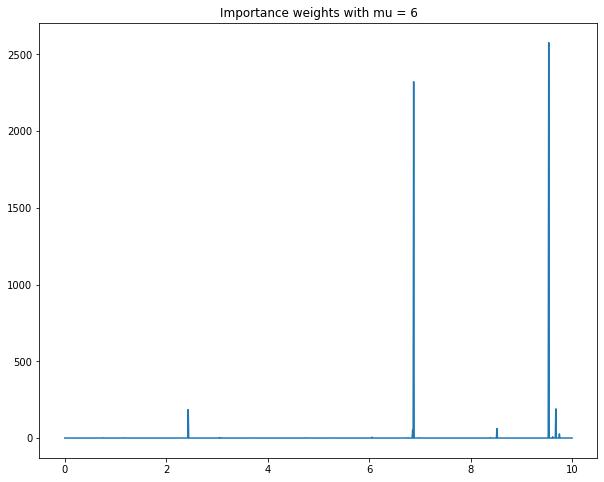

Mu estime =  0.7116101667274427
Sigma^2 estime =  1.6808512041387025


N =  10000


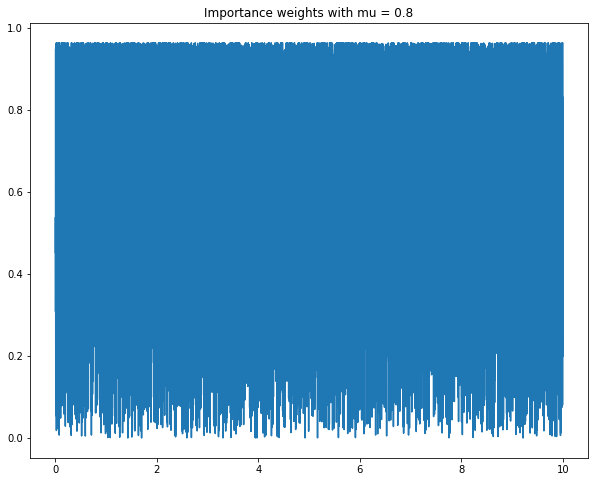

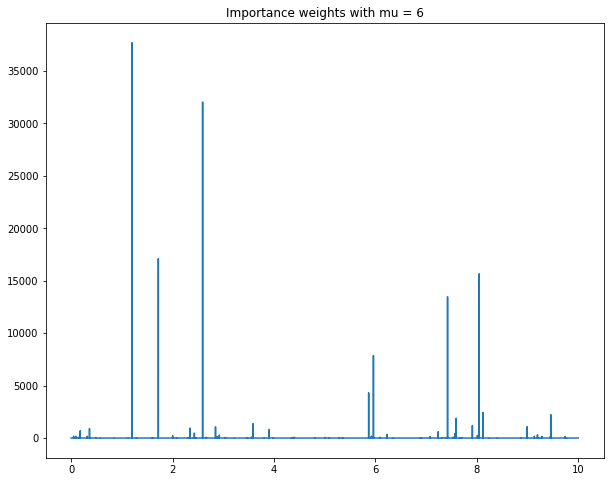

Mu estime =  0.6809120740726734
Sigma^2 estime =  1.7024152597919693




In [ ]:
for n in N:
  E, V, W = simple_importance_sampling(n)
  E_6, V_6, W_6 = simple_importance_sampling(n, mu=6)

  print("N = ", n)
  plt.figure(figsize=(10,8))
  plt.title("Importance weights with mu = 0.8")
  plt.plot(np.linspace(0, 10, len(W)), W)
  plt.show()

  plt.figure(figsize=(10,8))
  plt.title("Importance weights with mu = 6")
  plt.plot(np.linspace(0, 10, len(W_6)), W_6)
  plt.show()
  print("Mu estime = ", E)
  print("Sigma^2 estime = ", V)
  print("\n")

On remarque que pour un décalage de mu à 6, les pondérations d'importance (importance weights) sont quasiment tous nulles par rapport à ce qu'on avait pour mu = 0.8 .


### Question 4

En grande partie inspiré du document : https://hal.archives-ouvertes.fr/hal-00180669v4/document?fbclid=IwAR00s6OYPzeVo7YMZCbTJrap_K84pi5wm5OfchEDA32sgpg3bmdFQ8BrZvQ

Réponse sur feuille.

### Question 5

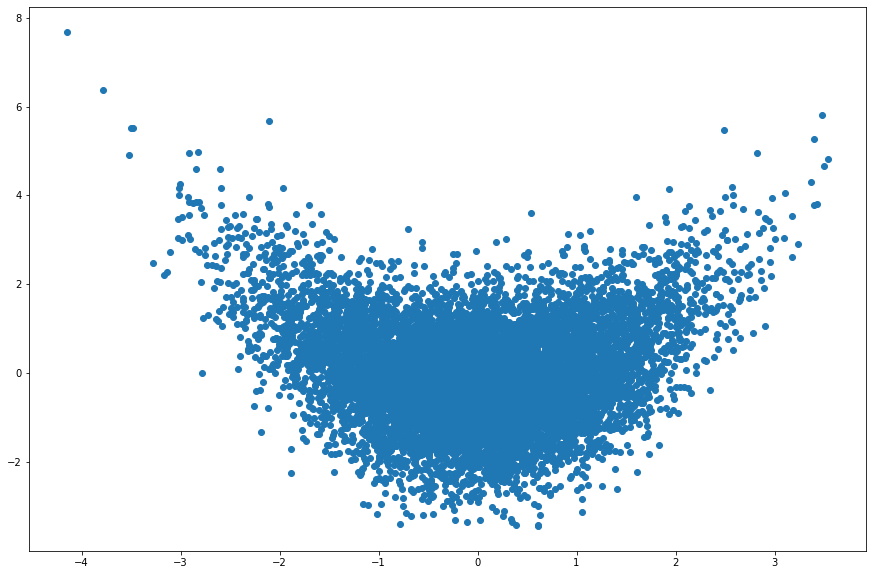

In [11]:
def sample_banana(n, d, sigma, b):
    S = np.eye(d)
    S[0,0] = sigma**2
    mu = np.zeros(d) 
    sample = np.random.multivariate_normal(mu, S, n)
    sample[:,1] += b * (sample[:,0]**2 - sigma**2) #on change la seconde coordonnee x2
    
    return(sample)

X = sample_banana(10000, 5, 1, 0.4)
plt.figure(figsize=(15,10))
plt.scatter(X[:,0], X[:,1])

On remarque bien que la densité a une forme de banane lorsque l'on représente ses deux premières coordonnées sur un graphique.